In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom
import  statsmodels.stats.multitest as multitest
from scipy.stats import ttest_ind
# import scipy.stats as stats
import scipy.stats as ss
import sys
sys.path.append('/projects/trans_scratch/validations/workspace/szong/Cervical/notebook')
import sz_toolbox as szt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

i am specifically looking into if non coding mutations are associated with any changes in gene expression

# 1. all files/constants

In [1]:
num_patients = 118
bgwindow_size = 1e4
patf = '/projects/trans_scratch/validations/workspace/szong/Cervical/118_patients.txt'
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/rainstorm/'
# inmaf = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients.maf'
# valhotspotsf = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/123_patients/sliding_window_mutaional_distance_merged_overlap_promoter_txn_factor_merged.txt'
nc_maf = '/projects/da_workspace/software/mutation_rainstorm/118_patients_noncoding/118_patients_noncoding.maf'
hsf = '/projects/da_workspace/software/mutation_rainstorm/118_patients_noncoding/waveletSummary_withMaf.tsv'
tssf = '/home/szong/projects/resource/ens69/hg19v69_genes.TSS_2000.pc.bed'
mapf = '/gsc/resources/annotation/ensembl/hugo_map_table.tsv'
exprf = '/projects/trans_scratch/validations/workspace/szong/Cervical/expression/NCI_ensembl69_stranded_RPKM_matrix_123samples_HUGOnoDups.txt'
isoformsf = '/projects/trans_scratch/validations/workspace/szong/Cervical/isoforms/isoforms_neg.txt'

# expression matrix

In [26]:
expr = pd.read_csv(exprf, sep='\t')
# expr['gene'] = expr['gene'].apply(lambda x: '_'.join(x.split('_')[1:]))
expr.head()

,gene,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,...,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447,HTMCP-03-06-02448
0,10_PPIB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12_FKBP10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13_CALCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15_UBE3A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16_ADA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 118 patients in the cohort

In [112]:
patients = pd.read_csv(patf, header=None)[0].tolist()
patients[:2]

['HTMCP-03-06-02002', 'HTMCP-03-06-02006']

# read in TSS coordinates 

In [29]:
tss = pd.read_csv(tssf, sep='\t',header=None)
tss.columns = ['chrom', 'start', 'end', 'ens69id']
tss.head()

,chrom,start,end,ens69id
0,1,34081,38080,ENSG00000237613
1,1,67092,71091,ENSG00000186092
2,1,365641,369640,ENSG00000235249
3,1,620053,624052,ENSG00000185097
4,1,858261,862260,ENSG00000187634


In [30]:
mapping = pd.read_csv(mapf, sep='\t')
mapping.head()

,hugo,hgnc_id,ens69_ensid,ens80_ensid
0,A1BG,HGNC:5,ENSG00000121410,ENSG00000121410
1,A1BG-AS1,HGNC:37133,NaN,ENSG00000268895
2,A1CF,HGNC:24086,ENSG00000148584,ENSG00000148584
3,A2M,HGNC:7,ENSG00000175899,ENSG00000175899
4,A2M-AS1,HGNC:27057,ENSG00000245105,ENSG00000245105


In [31]:
tss = pd.merge(tss, mapping, left_on='ens69id', right_on='ens69_ensid').drop(['ens69id', 'hgnc_id', 'ens69_ensid', 'ens80_ensid'], axis=1)

In [32]:
tss.head()

,chrom,start,end,hugo
0,1,34081,38080,FAM138A
1,1,67092,71091,OR4F5
2,1,365641,369640,OR4F29
3,1,620053,624052,OR4F16
4,1,858261,862260,SAMD11


In [33]:
# FAM231A is not in the expression matrix, so remove it
tss = tss[tss.hugo != 'FAM231A']

# 2. mutation matrix

In [8]:
muts = pd.read_csv(nc_maf, sep='\t', low_memory=False)
muts[:2]

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER
0,OR4G11P,0,.,GRCh37,1,59734,59734,+,5'Flank,SNP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS
1,RP11-206L10.5,0,.,GRCh37,1,694016,694016,+,3'Flank,SNP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS


In [9]:
keep = ['Hugo_Symbol',  'Chromosome', 'Start_Position', 'End_Position',  
        'Variant_Classification', 'Variant_Type', 'Tumor_Sample_Barcode', 'IMPACT']


In [10]:
muts.shape
muts = muts[keep]
muts['Variant_Type'].unique()
muts['IMPACT'].unique()
muts['Variant_Classification'].unique()

(2669443, 109)

array(['SNP', 'INS', 'DEL'], dtype=object)

array(['MODIFIER', 'LOW', 'HIGH'], dtype=object)

array(["5'Flank", "3'Flank", 'IGR', "3'UTR", 'Intron', "5'UTR", 'RNA',
       'Splice_Site', 'Translation_Start_Site'], dtype=object)

In [11]:
muts['patient'] = muts['Tumor_Sample_Barcode'].apply(lambda x: x.split('_T')[0])

In [12]:
muts.head(2)
muts.shape

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Classification,Variant_Type,Tumor_Sample_Barcode,IMPACT,patient
0,OR4G11P,1,59734,59734,5'Flank,SNP,HTMCP-03-06-02001_T,MODIFIER,HTMCP-03-06-02001
1,RP11-206L10.5,1,694016,694016,3'Flank,SNP,HTMCP-03-06-02001_T,MODIFIER,HTMCP-03-06-02001


(2669443, 9)

In [52]:
muts[muts.Hugo_Symbol== gene_of_interest]['patient'].nunique()

75

In [215]:
muts.to_csv(f'{wkdir}mutation_matrix.txt', index=False)

# 3. rainstorm hotspots

In [5]:
hs = pd.read_csv(hsf, sep='\t', low_memory=False)
hs.head()
hs.shape


,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,sdOfmutrate,mutPerKb,Hugo_Symbol
1_130.1,10,118649,127947,124617,-4.725319,34,6.774922,3'Flank,5.171064,-2.650349,0.929096,3.978922,TUBB8
1_230.1,10,309876,310856,310617,-2.743790,7,7.135576,IGR,3.540816,-1.893609,0.638003,7.135576,UnknownGene
1_275.1,10,417609,417685,417609,-3.661250,5,77.922078,Intron,4.517758,-2.333202,0.745806,64.935065,DIP2C
1_530.1,10,781351,784410,783607,-3.913474,16,6.209150,IGR,5.303916,-2.388440,0.998424,5.555556,UnknownGene
1_786.1,10,1258065,1258630,1258577,-4.723719,6,12.367491,Intron,4.099677,-2.617559,1.687188,10.600707,ADARB2


(3094, 13)

In [21]:
gene_of_interest = 'MAP3K13'

In [22]:
tert_hs = hs[hs.Hugo_Symbol == gene_of_interest]
tert_hs

,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,sdOfmutrate,mutPerKb,Hugo_Symbol
1_98067.1,3,185170345,185173637,185173115,-5.148451,43,21.560887,Intron,4.664564,-3.572835,1.072578,14.2727,MAP3K13


In [23]:
genes = hs.Hugo_Symbol.unique()
genes, len(genes)
gene_of_interest in genes

(array(['TUBB8', 'UnknownGene', 'DIP2C', ..., 'ABCD1', 'TMLHE', 'WASIR1'],
       dtype=object), 1425)

True

In [272]:
tss = tss[tss.hugo.isin(genes)]

In [274]:
tss.head()
tss[tss.hugo == 'TERT']
tss.shape

,chrom,start,end,hugo
13,1,1049741,1053740,C1orf159
14,1,1107265,1111264,TTLL10
43,1,1588473,1592472,CDK11B
45,1,1653777,1657776,CDK11A
55,1,2158135,2162134,SKI


,chrom,start,end,hugo
14231,5,1293184,1297183,TERT


(724, 4)

# 4. compare expression: wild type vs mutants

In [254]:
sns.boxplot?

In [62]:
def box_swarmplot(ax, df, xcol, ycol, gene, group_order, p, wkdir):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    _ = sns.boxplot(xcol, ycol, data=df, ax=ax, order=group_order, whis=np.inf)
    _ = sns.swarmplot(xcol, ycol, data=df, ax=ax, order=group_order)
    _ = ax.text(0.4 , 0.90, f't_p={p}', ha='center', va='center', transform=ax.transAxes, size=14)
    _ = ax.set_title(gene)
    _ = ax.set_xlabel('')
    
    for mbox in ax.artists:
        _ = mbox.set_facecolor('white')
    of = f'{wkdir}{gene}.png'
    plt.savefig(of, dpi=100) 


In [49]:
expr.head()

,gene,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,...,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447,HTMCP-03-06-02448
0,PPIB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FKBP10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CALCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,UBE3A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ADA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
expr[expr.gene == gene_of_interest]

,gene,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,...,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447,HTMCP-03-06-02448
21432,MAP3K13,8.1337,11.5536,3.0578,6.7422,2.6381,4.4349,6.1125,2.3207,4.3121,...,5.3073,2.7589,4.5444,2.5605,2.4502,3.8761,3.5548,1.5971,7.0369,2.1763


In [35]:
tss = tss[tss.hugo == gene_of_interest]
tss

,chrom,start,end,hugo
13387,3,184998730,185002729,MAP3K13


In [125]:
region_of_interest = [[9, 133660206, 133660760]]
gene_of_interest ='ABL1'


looking at ABL1


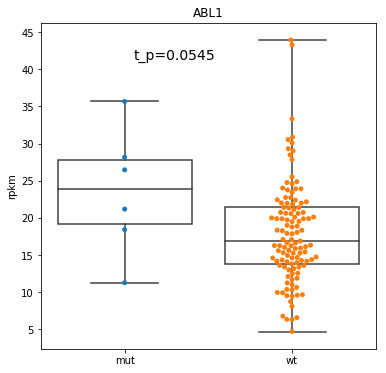

In [126]:

dif_genes = []
for rg in region_of_interest:
    chrom = rg[0]
    start = rg[1]
    end = rg[2]
    gene = gene_of_interest
    
    print(f'looking at {gene_of_interest}')
    muts_chr = muts[muts.Chromosome == str(chrom)]
    gene_subset = muts_chr[(((muts_chr.Start_Position >= start)&(muts_chr.Start_Position <= end))|
                          ((muts_chr.End_Position >= start)&(muts_chr.End_Position <= end)))]
#     print(gene_subset)
    mutpats = gene_subset['patient'].unique()
    wtpats = szt.unique2a(patients, mutpats)
    assert len(mutpats) + len(wtpats) == num_patients
    

    gene_expr = expr[expr.gene==gene].drop('gene', axis=1)
#     sometime all expressions are close to zero
    if (not gene_expr.empty) and (gene_expr.values.max() >1):
        gene_expr = gene_expr.T.reset_index()
        gene_expr.columns = ['patient', 'rpkm']
        gene_expr['rpkm'] =  gene_expr['rpkm'].astype(float)
        gene_expr['group'] = gene_expr.patient.apply(lambda x: 'mut' if x in mutpats else 'wt' )
        mutrpkm = gene_expr[gene_expr.patient.isin(mutpats)]['rpkm'].values.ravel()
        wtrpkm = gene_expr[gene_expr.patient.isin(wtpats)]['rpkm'].values.ravel()
        sts, p1 = ttest_ind(mutrpkm, wtrpkm) # 2-sided test
        sts, p2 = ss.mannwhitneyu(mutrpkm, wtrpkm, use_continuity=True, alternative=None)
        p1, p2 = round(p1, 4), round(p2,4)
#         print(gene, len(mutrpkm), len(wtrpkm), p1, p2)
#         if (p1 < 0.05) and (len(mutrpkm)>3) and (len(wtrpkm)>3):
        box_swarmplot(ax, gene_expr, 'group', 'rpkm', gene, ['mut', 'wt'], p1, wkdir)
#         print(f'{wkdir}/{gene} mutated patients are:')
#         print(gene_expr[gene_expr.group == 'mut']['patient'])
        dif_genes.append(gene)


In [127]:
mutpats

array(['HTMCP-03-06-02128', 'HTMCP-03-06-02155', 'HTMCP-03-06-02266',
       'HTMCP-03-06-02267', 'HTMCP-03-06-02354', 'HTMCP-03-06-02261'],
      dtype=object)

In [123]:
hs[hs.Hugo_Symbol=='ABL1']

,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,sdOfmutrate,mutPerKb,Hugo_Symbol
1_58007.1,9,133660206,133660760,133660760,-8.216036,6,10.810811,Intron,12.079107,-7.122963,2.515833,10.810811,ABL1


In [76]:
dftmp = muts[muts.Hugo_Symbol=='TERT']

dftmp[(dftmp.Start_Position>=1284550)&(dftmp.Start_Position<=1284686)].sort_values('Start_Position')

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Classification,Variant_Type,Tumor_Sample_Barcode,IMPACT,patient
843281,TERT,5,1284568,1284568,Intron,SNP,HTMCP-03-06-02110_T,MODIFIER,HTMCP-03-06-02110
863960,TERT,5,1284608,1284608,Intron,SNP,HTMCP-03-06-02120_T,MODIFIER,HTMCP-03-06-02120
863961,TERT,5,1284614,1284614,Intron,SNP,HTMCP-03-06-02120_T,MODIFIER,HTMCP-03-06-02120
2634168,TERT,5,1284628,1284628,Intron,SNP,HTMCP-03-06-02262_T,MODIFIER,HTMCP-03-06-02262
863962,TERT,5,1284638,1284638,Intron,SNP,HTMCP-03-06-02120_T,MODIFIER,HTMCP-03-06-02120
1887640,TERT,5,1284638,1284638,Intron,SNP,HTMCP-03-06-02268_T,MODIFIER,HTMCP-03-06-02268
1985121,TERT,5,1284650,1284650,Intron,SNP,HTMCP-03-06-02330_T,MODIFIER,HTMCP-03-06-02330
2579410,TERT,5,1284650,1284650,Intron,SNP,HTMCP-03-06-02441_T,MODIFIER,HTMCP-03-06-02441
422504,TERT,5,1284652,1284652,Intron,SNP,HTMCP-03-06-02063_T,MODIFIER,HTMCP-03-06-02063
133199,TERT,5,1284668,1284668,Intron,SNP,HTMCP-03-06-02020_T,MODIFIER,HTMCP-03-06-02020


In [77]:
patients_E2F1_affected = ['HTMCP-03-06-02020', 
'HTMCP-03-06-02071',
'HTMCP-03-06-02110',
'HTMCP-03-06-02328',
'HTMCP-03-06-02330',
'HTMCP-03-06-02441'
]

# this looks into any mutations within a gene

number of wt patient: 112
looking at TERT
mutant patients = 6, wt patients=112


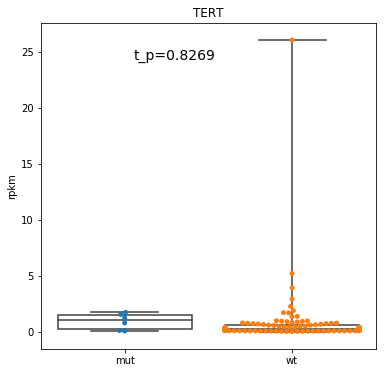

In [115]:

# dif_genes = []
# for ix, row in tss.iterrows():
#     chrom = row.chrom
#     start = row.start
#     end = row.end
#     gene = row.hugo
gene_of_interest = 'TERT'  
chrom = 5
# remove outlier 2240
# patients.remove('HTMCP-03-06-02240')
print(f'number of wt patient: {len(wtpats)}')
print(f'looking at {gene_of_interest}')
muts_chr = muts[muts.Chromosome == str(chrom)]
gene_subset = muts_chr[muts_chr.Hugo_Symbol == gene_of_interest]
# print(gene_subset)
# mutpats = gene_subset['patient'].unique()
mutpats = patients_E2F1_affected
wtpats = [pat for pat in patients if pat not in mutpats]
# wtpats = szt.unique2a(patients, mutpats)
assert len(mutpats) + len(wtpats) == num_patients 
print(f'mutant patients = {len(mutpats)}, wt patients={len(wtpats)}')


gene_expr = expr[expr.gene==gene_of_interest].drop('gene', axis=1)
#     sometime all expressions are close to zero

gene_expr = gene_expr.T.reset_index()
gene_expr.columns = ['patient', 'rpkm']
gene_expr['rpkm'] =  gene_expr['rpkm'].astype(float)
gene_expr['group'] = gene_expr.patient.apply(lambda x: 'mut' if x in mutpats else 'wt' )
# gene_expr = gene_expr[gene_expr.patient != 'HTMCP-03-06-02240']
# print(gene_expr.sort_values('group'))



mutrpkm = gene_expr[gene_expr.patient.isin(mutpats)]['rpkm'].values.ravel()
wtrpkm = gene_expr[gene_expr.patient.isin(wtpats)]['rpkm'].values.ravel()
sts, p1 = ttest_ind(mutrpkm, wtrpkm) # 2-sided test
sts, p2 = ss.mannwhitneyu(mutrpkm, wtrpkm, use_continuity=True, alternative=None)
p1, p2 = round(p1, 4), round(p2,4)
#         print(gene, len(mutrpkm), len(wtrpkm), p1, p2)
#         if (p1 < 0.05) and (len(mutrpkm)>3) and (len(wtrpkm)>3):
box_swarmplot(ax, gene_expr, 'group', 'rpkm', gene_of_interest, ['mut', 'wt'], p1, wkdir)
#     print(f'{gene} mutated patients are:')
#     print(gene_expr[gene_expr.group == 'mut']['patient'])
#     dif_genes.append(gene)


In [ ]:
9	133660206	133660760

In [122]:
# muts.head()
muts[(muts.Hugo_Symbol=='ABL1')&(muts.Start_Position>=133660206)&(muts.Start_Position<=133660760)]['patient']

894658     HTMCP-03-06-02128
1047708    HTMCP-03-06-02155
1868764    HTMCP-03-06-02266
1880064    HTMCP-03-06-02267
2216486    HTMCP-03-06-02354
2661899    HTMCP-03-06-02261
Name: patient, dtype: object

In [107]:
gene_expr[gene_expr.patient.isin(wtpats)].sort_values('rpkm', ascending=False)
# len(wtpats)

,patient,rpkm,group
30,HTMCP-03-06-02098,5.1766,wt
28,HTMCP-03-06-02092,3.8967,wt
104,HTMCP-03-06-02346,2.8998,wt
6,HTMCP-03-06-02012,2.2479,wt
85,HTMCP-03-06-02259,1.8660,wt
90,HTMCP-03-06-02266,1.6876,wt
66,HTMCP-03-06-02204,1.6660,wt
110,HTMCP-03-06-02411,1.3531,wt
73,HTMCP-03-06-02216,1.3267,wt
15,HTMCP-03-06-02047,0.9603,wt


In [44]:
muts_chr[muts_chr.Hugo_Symbol == gene_of_interest]

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Classification,Variant_Type,Tumor_Sample_Barcode,IMPACT,patient
5793,MAP3K13,3,185172936,185172936,Intron,SNP,HTMCP-03-06-02001_T,MODIFIER,HTMCP-03-06-02001
5794,MAP3K13,3,185172939,185172939,Intron,SNP,HTMCP-03-06-02001_T,MODIFIER,HTMCP-03-06-02001
28681,MAP3K13,3,185032646,185032646,Intron,SNP,HTMCP-03-06-02002_T,MODIFIER,HTMCP-03-06-02002
28682,MAP3K13,3,185034874,185034874,Intron,SNP,HTMCP-03-06-02002_T,MODIFIER,HTMCP-03-06-02002
28683,MAP3K13,3,185173666,185173666,Intron,SNP,HTMCP-03-06-02002_T,MODIFIER,HTMCP-03-06-02002
28684,MAP3K13,3,185205051,185205051,3'UTR,SNP,HTMCP-03-06-02002_T,MODIFIER,HTMCP-03-06-02002
42737,MAP3K13,3,185172715,185172715,Intron,SNP,HTMCP-03-06-02003_T,MODIFIER,HTMCP-03-06-02003
69945,MAP3K13,3,185105319,185105319,Intron,SNP,HTMCP-03-06-02008_T,MODIFIER,HTMCP-03-06-02008
69946,MAP3K13,3,185111481,185111481,Intron,SNP,HTMCP-03-06-02008_T,MODIFIER,HTMCP-03-06-02008
86311,MAP3K13,3,185014841,185014841,Intron,SNP,HTMCP-03-06-02012_T,MODIFIER,HTMCP-03-06-02012


In [278]:
szt.list2csv(dif_genes, f'{wkdir}differentially_expressed_rainstorm_genes.txt')

# compare isoforms

In [4]:
# read in isoforms
isoforms = pd.read_csv(isoformsf)
isoforms.set_index('transcript', inplace=True)
isoforms

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02036,HTMCP-03-06-02037,...,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447
transcript,,,,,,,,,,,,,,,,,,,,,
ENST00000296820,0.030587,0.049220,0.089336,0.0,0.249544,0.624736,0.045503,0.000000,0.032877,0.000000,...,0.069781,0.000000,0.000000,0.028269,0.000000,0.044146,0.000000,1.137000,0.000000,0.000000
ENST00000508104,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENST00000334602,0.000000,0.015010,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.296127,0.000000,0.162024,0.000000,0.139591,0.138158
ENST00000310581,0.098013,0.021332,0.143158,0.0,0.016949,1.704590,0.036992,0.101228,0.170665,0.152239,...,0.000000,0.069270,0.000000,0.000000,0.058421,0.000000,0.041343,0.668444,0.035813,0.061137
ENST00000460137,0.000000,0.047795,0.000000,0.0,0.000000,0.127642,0.000000,0.000000,0.011467,0.000000,...,0.000000,0.000000,0.000000,0.185482,0.000000,0.000000,0.000000,0.238442,0.000000,0.024372
ENST00000522877,0.000000,0.000000,0.000000,0.0,0.000000,0.079057,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENST00000503656,0.000000,0.000000,0.413896,0.0,0.462458,6.638280,0.321471,0.191456,0.510736,0.146406,...,0.000000,0.061922,0.067182,0.918096,1.782080,0.165217,0.000000,5.240340,0.173809,0.219859
ENST00000484238,0.095987,0.210852,0.434865,0.0,0.278292,3.659870,0.088283,0.128414,0.361733,0.193523,...,0.108269,0.055833,0.113863,0.073869,0.675965,0.077069,0.070678,2.593990,0.121068,0.199399


In [7]:
tert_hs.head(2)

,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,sdOfmutrate,mutPerKb,Hugo_Symbol
1_12161.1,5,1283266,1284668,1284638,-5.076626,18,16.393443,Intron,5.107894,-3.557077,1.434621,12.829651,TERT
1_1259.1,5,1295228,1295250,1295228,-7.762693,13,565.217391,5'Flank,12.358292,-6.504207,2.815591,521.739130,TERT


1_12161.1 TERT ENST00000296820 18 100 0.1617
1_12161.1 TERT ENST00000508104 18 100 0.7894
1_12161.1 TERT ENST00000334602 18 100 0.9185
1_12161.1 TERT ENST00000310581 18 100 0.6266
1_12161.1 TERT ENST00000460137 18 100 0.2246
1_12161.1 TERT ENST00000522877 18 100 0.7884
1_12161.1 TERT ENST00000503656 18 100 0.8191
1_12161.1 TERT ENST00000484238 18 100 0.7158
1_1259.1 TERT ENST00000296820 13 105 0.0352
1_1259.1 TERT ENST00000508104 13 105 0.5499
1_1259.1 TERT ENST00000334602 13 105 0.7779
1_1259.1 TERT ENST00000310581 13 105 0.606
1_1259.1 TERT ENST00000460137 13 105 0.0009
1_1259.1 TERT ENST00000522877 13 105 0.5627
1_1259.1 TERT ENST00000503656 13 105 0.4737
1_1259.1 TERT ENST00000484238 13 105 0.519


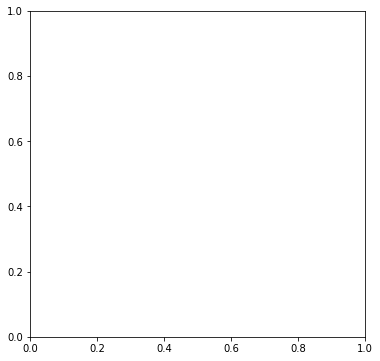

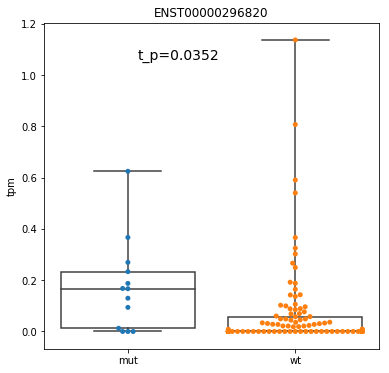

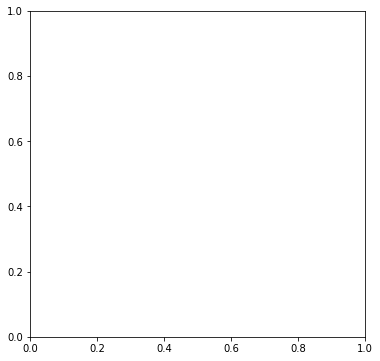

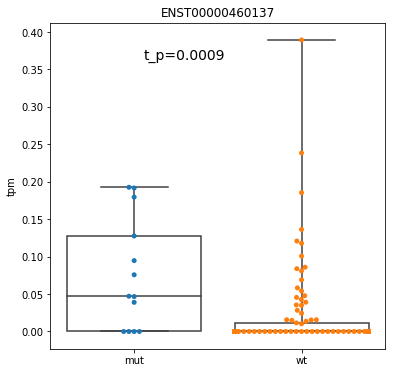

In [18]:
for ix, row in tert_hs.iterrows():
    chrom = row.chromosome
    start = row.leftPosition
    end = row.rightPosition
    gene = row.Hugo_Symbol
    
#     print(gene)
    muts_chr = muts[muts.Chromosome == str(chrom)]
#     print(muts_chr)
    gene_subset = muts_chr[(((muts_chr.Start_Position >= start)&(muts_chr.Start_Position <= end))|
                          ((muts_chr.End_Position >= start)&(muts_chr.End_Position <= end)))]
#     print(gene_subset)
    mutpats = gene_subset['patient'].unique()
    wtpats = szt.unique2a(patients, mutpats)
    assert len(mutpats) + len(wtpats) == num_patients
#     mutpats
#     wtpats
    
    for iso in isoforms.index:
#         print(ix, iso)
        iso_expr = isoforms.loc[iso]
        mut_expr = iso_expr[mutpats].values.ravel()
        wt_expr = iso_expr[wtpats].values.ravel()
        iso_expr = iso_expr.T.reset_index()
        iso_expr.columns = ['patient', 'tpm']
        iso_expr['group'] = iso_expr.patient.apply(lambda x: 'mut' if x in mutpats else 'wt' )
#         print(mut_expr)
        sts, p1 = ttest_ind(mut_expr, wt_expr) # 2-sided test
#         Use manwhiteneyu test only when the number of observation in each sample is > 20 and you have 2 independent samples of ranks. 
        sts, p2 = ss.mannwhitneyu(mut_expr, wt_expr, use_continuity=True, alternative=None)
        p1, p2 = round(p1, 4), round(p2,4)
        
        print(ix, gene, iso, len(mut_expr), len(wt_expr), p1)
        if (p1 < 0.05) and (len(mut_expr)>3) and (len(wt_expr)>3):
            fig, ax = plt.subplots(figsize=(6,6))
            box_swarmplot(ax, iso_expr, 'group', 'tpm', iso, ['mut', 'wt'], p1)


In [269]:
!pwd

/projects/trans_scratch/validations/workspace/szong/Cervical/notebook
